<a href="https://colab.research.google.com/github/Preeti0357/projects/blob/main/ubertrip.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
pip install pandas numpy matplotlib seaborn scikit-learn xgboost

In [2]:
import warnings
warnings.filterwarnings("ignore")
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, TimeSeriesSplit
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error, r2_score
import xgboost as xgb
from statsmodels.tsa.seasonal import seasonal_decompose

In [3]:
def PlotDecomposition(result, title='Seasonal Decomposition'):
    plt.figure(figsize=(22, 18))
    plt.subplot(4, 1, 1)
    plt.plot(result.observed, label='Observed', lw=1)
    plt.legend(loc='upper left')
    plt.subplot(4, 1, 2)
    plt.plot(result.trend, label='Trend', lw=1)
    plt.legend(loc='upper left')
    plt.subplot(4, 1, 3)
    plt.plot(result.seasonal, label='Seasonality', lw=1)
    plt.legend(loc='upper left')
    plt.subplot(4, 1, 4)
    plt.plot(result.resid, label='Residuals', lw=1)
    plt.legend(loc='upper left')
    plt.suptitle(title)
    plt.savefig('decomposition.png')
    plt.show()

def PlotPredictions(plots, title):
    plt.figure(figsize=(18, 8))
    for plot in plots:
        plt.plot(plot[0], plot[1], label=plot[2], linestyle=plot[3], color=plot[4], lw=1)
    plt.xlabel('Date')
    plt.ylabel('Trips')
    plt.title(title)
    plt.legend()
    plt.xticks(rotation=30, ha='right')
    plt.savefig(f'{title.lower().replace(" ", "_")}.png')
    plt.show()

In [6]:
# Read the data file
uber2014 = pd.read_csv('/content/Uber-Jan-Feb-FOIL.csv')

# Convert date to datetime and sort
uber2014['date'] = pd.to_datetime(uber2014['date'])
uber2014 = uber2014.sort_values(by='date')
uber2014.rename(columns={'date': 'Date'}, inplace=True)

In [9]:
# Ensure Date is a column before setting as index
if 'Date' not in uber2014.columns and uber2014.index.name == 'Date':
    uber2014.reset_index(inplace=True)
elif 'Date' not in uber2014.columns and uber2014.index.name is not None:
    uber2014.reset_index(inplace=True)
    uber2014.rename(columns={uber2014.index.name: 'Date'}, inplace=True)

# Set Date as index
uber2014.set_index('Date', inplace=True)

# Resample to hourly counts by averaging daily trips over 24 hours
hourly_counts = uber2014['trips'].resample('H').mean() / 24
uber2014 = hourly_counts.reset_index()

# Rename columns and set Date as index
uber2014.columns = ['Date', 'Hourly Count']
uber2014.set_index('Date', inplace=True)

# Display first few rows
print(uber2014.head())

                     Hourly Count
Date                             
2015-01-01 00:00:00    391.923611
2015-01-01 01:00:00           NaN
2015-01-01 02:00:00           NaN
2015-01-01 03:00:00           NaN
2015-01-01 04:00:00           NaN


In [10]:
# Ensure continuous hourly index
date_range = pd.date_range(start=uber2014.index.min(), end=uber2014.index.max(), freq='H')
uber2014 = uber2014.reindex(date_range, fill_value=0)
uber2014.columns = ['Count']
print(uber2014.isnull().sum())  # Should show 0

Count    1334
dtype: int64


In [11]:
print(uber2014.describe())

            Count
count   59.000000
mean   486.138183
std    109.945592
min    175.305556
25%    425.006944
50%    494.562500
75%    561.187500
max    700.798611


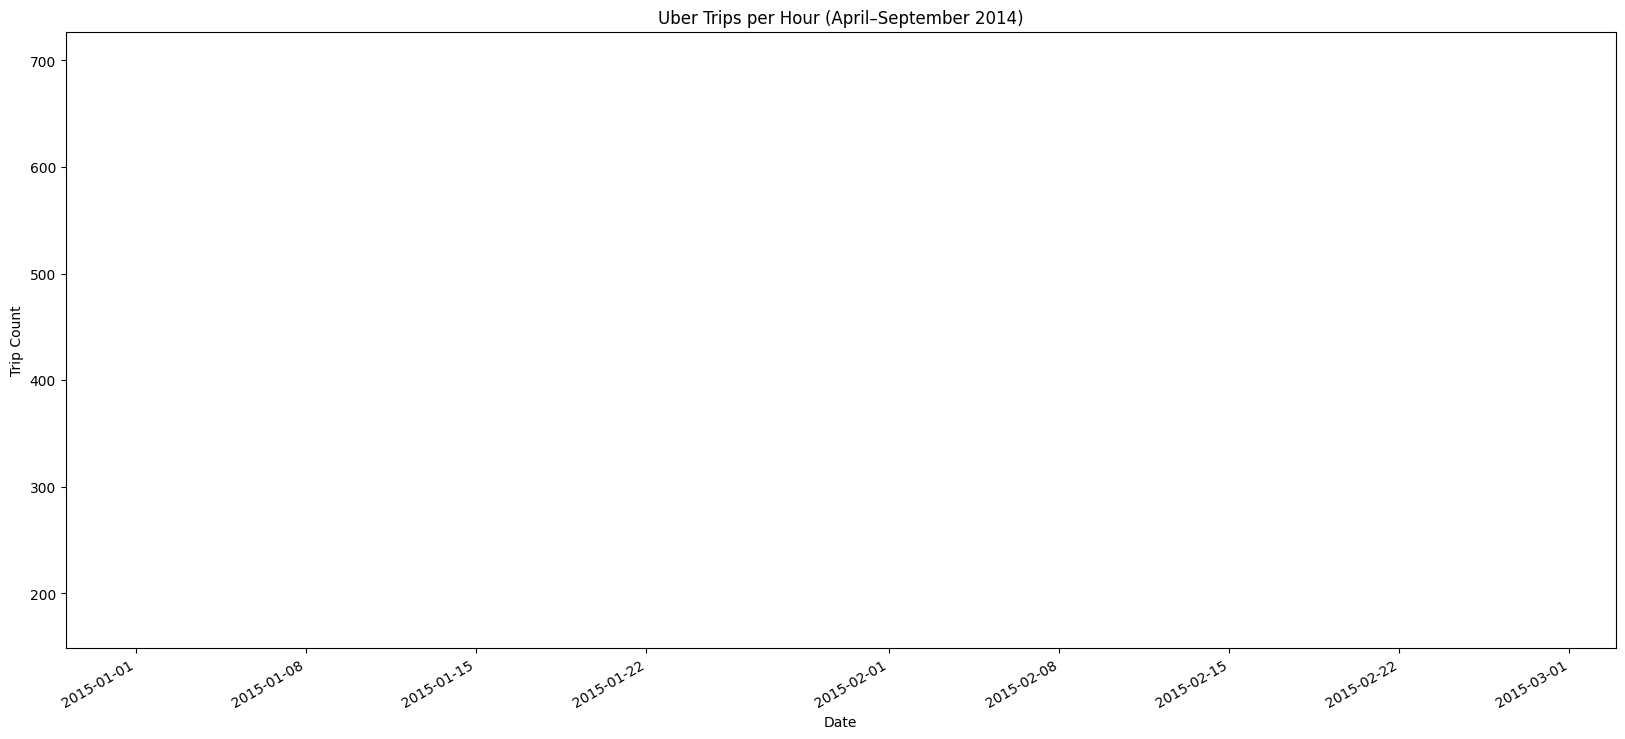

In [12]:
plt.figure(figsize=(20, 8))
plt.plot(uber2014['Count'], linewidth=1, color='darkslateblue')
plt.title('Uber Trips per Hour (April–September 2014)')
plt.xlabel('Date')
plt.ylabel('Trip Count')
plt.xticks(rotation=30, ha='right')
plt.savefig('trips_time_series.png')
plt.show()

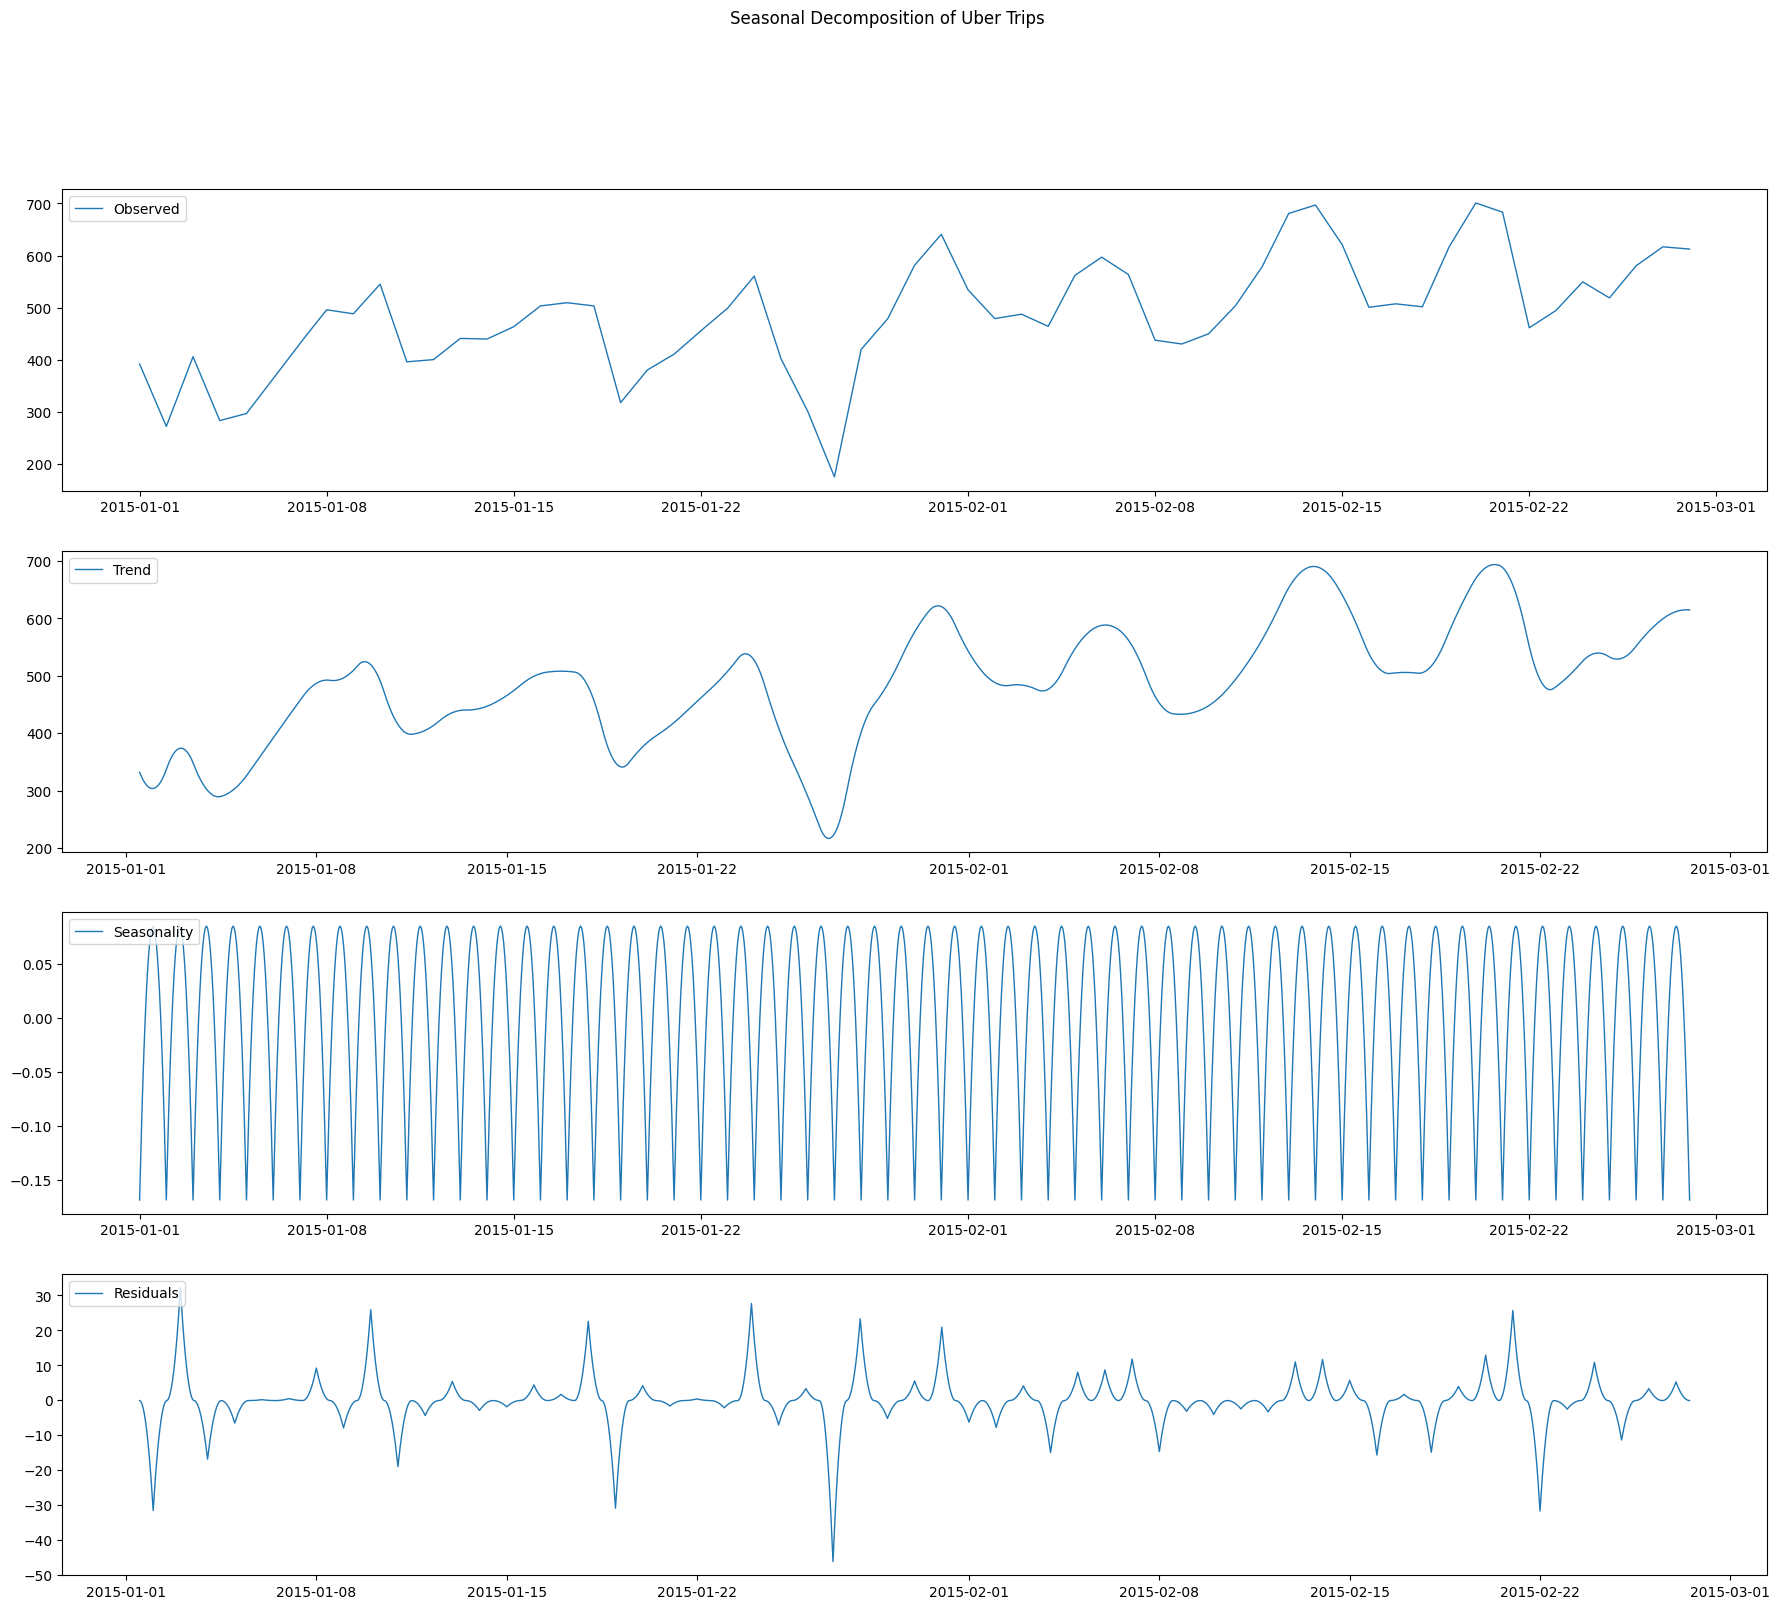

In [14]:
# Fill missing values using linear interpolation
uber2014['Count'].interpolate(method='linear', inplace=True)

result = seasonal_decompose(uber2014['Count'], model='additive', period=24)
PlotDecomposition(result, title='Seasonal Decomposition of Uber Trips')

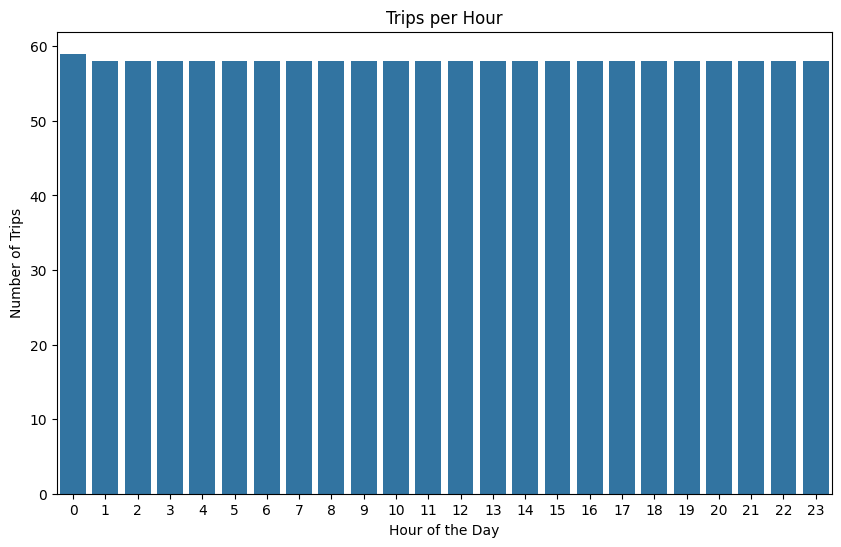

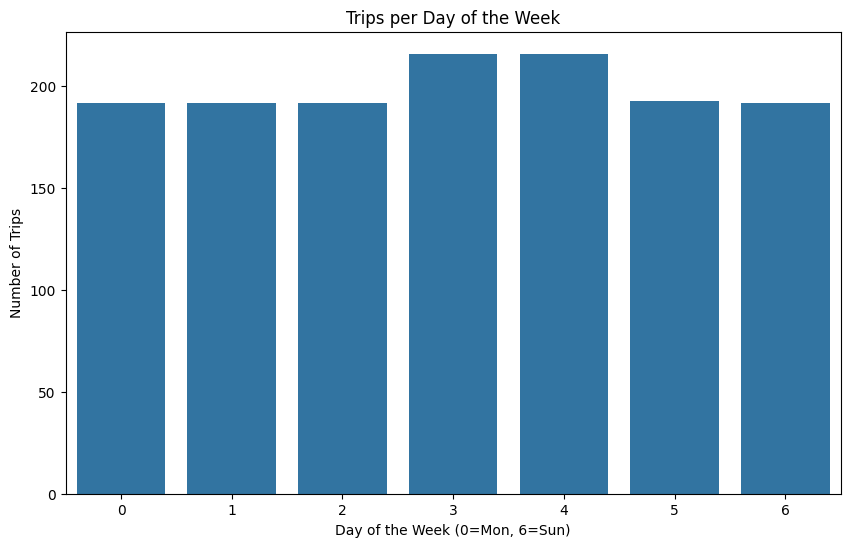

In [15]:
uber2014['Hour'] = uber2014.index.hour
uber2014['DayOfWeek'] = uber2014.index.dayofweek

# Trips per Hour
plt.figure(figsize=(10, 6))
sns.countplot(x='Hour', data=uber2014)
plt.title('Trips per Hour')
plt.xlabel('Hour of the Day')
plt.ylabel('Number of Trips')
plt.savefig('trips_per_hour.png')
plt.show()

# Trips per Day of Week
plt.figure(figsize=(10, 6))
sns.countplot(x='DayOfWeek', data=uber2014)
plt.title('Trips per Day of the Week')
plt.xlabel('Day of the Week (0=Mon, 6=Sun)')
plt.ylabel('Number of Trips')
plt.savefig('trips_per_dayofweek.png')
plt.show()

In [16]:
def create_lagged_features(data, window_size):
    X, y = [], []
    for i in range(len(data) - window_size):
        X.append(data[i:i + window_size])
        y.append(data[i + window_size])
    return np.array(X), np.array(y)

window_size = 24
X, y = create_lagged_features(uber2014['Count'].values, window_size)

In [17]:
uber2014['Hour'] = uber2014.index.hour
uber2014['Day'] = uber2014.index.day
uber2014['DayOfWeek'] = uber2014.index.dayofweek
uber2014['Month'] = uber2014.index.month

# Merge with lagged features
lagged_df = pd.DataFrame(X, columns=[f'Lag_{i+1}' for i in range(window_size)])
lagged_df['Hour'] = uber2014['Hour'].iloc[window_size:].reset_index(drop=True)
lagged_df['Day'] = uber2014['Day'].iloc[window_size:].reset_index(drop=True)
lagged_df['DayOfWeek'] = uber2014['DayOfWeek'].iloc[window_size:].reset_index(drop=True)
lagged_df['Month'] = uber2014['Month'].iloc[window_size:].reset_index(drop=True)
y = y  # Target remains the same

In [22]:
# Split data into training and testing sets
tscv = TimeSeriesSplit(n_splits=5) # You can adjust the number of splits
for train_index, test_index in tscv.split(lagged_df):
    X_train, X_test = lagged_df.iloc[train_index], lagged_df.iloc[test_index]
    y_train, y_test = y[train_index], y[test_index]

print("Training data shape (features):", X_train.shape)
print("Testing data shape (features):", X_test.shape)
print("Training data shape (target):", y_train.shape)
print("Testing data shape (target):", y_test.shape)

Training data shape (features): (1141, 28)
Testing data shape (features): (228, 28)
Training data shape (target): (1141,)
Testing data shape (target): (228,)


In [25]:
# Determine cutoff index for splitting data (e.g., 80% for training)
train_size = int(len(uber2014) * 0.8)
cutoff_index = uber2014.index[train_size]

uber2014_train = uber2014.loc[:cutoff_index]
uber2014_test = uber2014.loc[cutoff_index:]

# Create lagged features for train and test
X_train, y_train = create_lagged_features(uber2014_train['Count'].values, window_size)
test_data = np.concatenate([uber2014_train['Count'].values[-window_size:], uber2014_test['Count'].values])
X_test, y_test = create_lagged_features(test_data, window_size)

# Add temporal features
train_df = pd.DataFrame(X_train, columns=[f'Lag_{i+1}' for i in range(window_size)])
train_df['Hour'] = uber2014_train['Hour'].iloc[window_size:].reset_index(drop=True)
train_df['Day'] = uber2014_train['Day'].iloc[window_size:].reset_index(drop=True)
train_df['DayOfWeek'] = uber2014_train['DayOfWeek'].iloc[window_size:].reset_index(drop=True)
train_df['Month'] = uber2014_train['Month'].iloc[window_size:].reset_index(drop=True)

test_df = pd.DataFrame(X_test, columns=[f'Lag_{i+1}' for i in range(window_size)])
test_df['Hour'] = uber2014_test['Hour'].iloc[:len(X_test)].reset_index(drop=True)
test_df['Day'] = uber2014_test['Day'].iloc[:len(X_test)].reset_index(drop=True)
test_df['DayOfWeek'] = uber2014_test['DayOfWeek'].iloc[:len(X_test)].reset_index(drop=True)
test_df['Month'] = uber2014_test['Month'].iloc[:len(X_test)].reset_index(drop=True)

In [26]:
seed = 12345
tscv = TimeSeriesSplit(n_splits=5)
xgb_param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 6, 9],
    'learning_rate': [0.01, 0.1, 0.3],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0]
}
xgb_model = xgb.XGBRegressor(objective='reg:squarederror', random_state=seed)
xgb_grid_search = GridSearchCV(estimator=xgb_model, param_grid=xgb_param_grid, cv=tscv, scoring='neg_mean_absolute_percentage_error', n_jobs=-1, verbose=1)
xgb_grid_search.fit(train_df, y_train)
print("Best XGBoost parameters:", xgb_grid_search.best_params_)
xgb_predictions = xgb_grid_search.best_estimator_.predict(test_df)
xgb_mape = mean_absolute_percentage_error(y_test, xgb_predictions)
print(f"XGBoost MAPE: {xgb_mape:.2%}")

Fitting 5 folds for each of 243 candidates, totalling 1215 fits
Best XGBoost parameters: {'colsample_bytree': 1.0, 'learning_rate': 0.3, 'max_depth': 9, 'n_estimators': 100, 'subsample': 1.0}
XGBoost MAPE: 0.49%


In [27]:
gbr_param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.1],
    'max_depth': [3, 4, 5],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2']
}
gbr_model = GradientBoostingRegressor(random_state=seed)
gbr_grid_search = GridSearchCV(estimator=gbr_model, param_grid=gbr_param_grid, cv=tscv, scoring='neg_mean_absolute_percentage_error', n_jobs=-1, verbose=1)
gbr_grid_search.fit(train_df, y_train)
print("Best GBRT parameters:", gbr_grid_search.best_params_)
gbr_predictions = gbr_grid_search.best_estimator_.predict(test_df)
gbr_mape = mean_absolute_percentage_error(y_test, gbr_predictions)
print(f"GBRT MAPE: {gbr_mape:.2%}")

Fitting 5 folds for each of 324 candidates, totalling 1620 fits
Best GBRT parameters: {'learning_rate': 0.1, 'max_depth': 4, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 200}
GBRT MAPE: 1.23%


In [29]:
rf_param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': [None, 'sqrt', 'log2']
}
rf_model = RandomForestRegressor(random_state=seed)
rf_grid_search = GridSearchCV(estimator=rf_model, param_grid=rf_param_grid, cv=tscv, scoring='neg_mean_absolute_percentage_error', n_jobs=-1, verbose=1)
rf_grid_search.fit(train_df, y_train)
print("Best Random Forest parameters:", rf_grid_search.best_params_)
rf_predictions = rf_grid_search.best_estimator_.predict(test_df)
rf_mape = mean_absolute_percentage_error(y_test, rf_predictions)
print(f"Random Forest MAPE: {rf_mape:.2%}")

Fitting 5 folds for each of 243 candidates, totalling 1215 fits
Best Random Forest parameters: {'max_depth': 10, 'max_features': None, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 100}
Random Forest MAPE: 0.44%


In [30]:
weights = np.array([0.368, 0.322, 0.310])  # From document
ensemble_predictions = (weights[0] * xgb_predictions + weights[1] * rf_predictions + weights[2] * gbr_predictions)
ensemble_mape = mean_absolute_percentage_error(y_test, ensemble_predictions)
print(f"Ensemble MAPE: {ensemble_mape:.2%}")

Ensemble MAPE: 0.63%


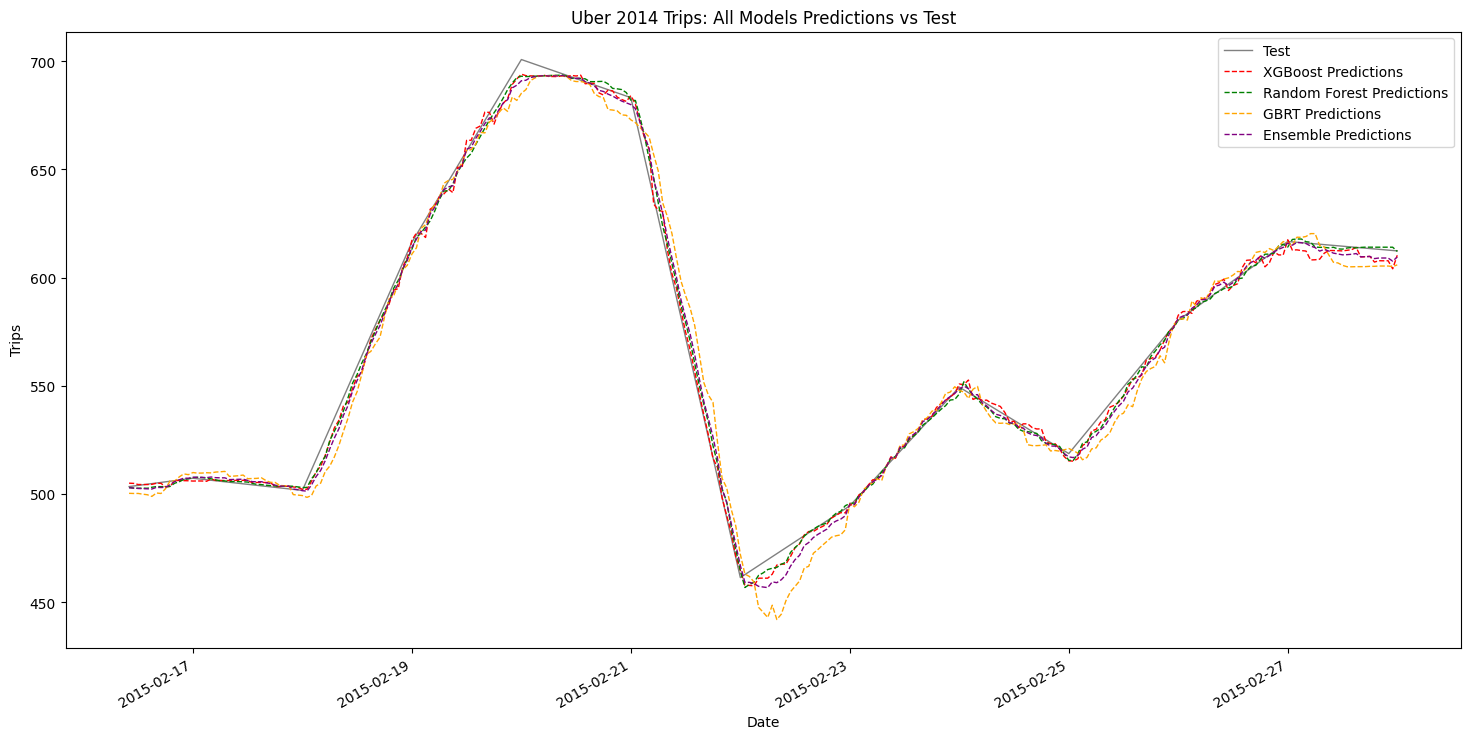

In [31]:
PlotPredictions([
    (uber2014_test.index[:len(y_test)], y_test, 'Test', '-', 'gray'),
    (uber2014_test.index[:len(y_test)], xgb_predictions, 'XGBoost Predictions', '--', 'red'),
    (uber2014_test.index[:len(y_test)], rf_predictions, 'Random Forest Predictions', '--', 'green'),
    (uber2014_test.index[:len(y_test)], gbr_predictions, 'GBRT Predictions', '--', 'orange'),
    (uber2014_test.index[:len(y_test)], ensemble_predictions, 'Ensemble Predictions', '--', 'purple')
], 'Uber 2014 Trips: All Models Predictions vs Test')